### Compute tune shift from space charge

Compute the incoherent tune shift due to direct space charge, assuming gaussian distribution for all planes and zero vertical dispersion.

Eq. (4.18a) and (4.18b) from Hannes thesis: https://cds.cern.ch/record/1644761/files/CERN-THESIS-2013-257.pdf

In [1]:
from scipy import integrate
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
def EnergySpread(Circumferance, Harmonic_Num, Energy_total, SlipF, BL, beta_rel, RF_Voltage, Energy_loss, Z):
    '~~~ from Wiedermanns book ~~~'
    return BL / (Circumferance * np.sqrt(SlipF * Energy_total / (2 * np.pi * beta_rel * Harmonic_Num * np.sqrt(Z**2 * RF_Voltage**2 - Energy_loss**2))))

In [3]:
def slip_factor(alpha_p, gamma_0):
    return alpha_p - 1/(gamma_0**2)

In [27]:
# Beam parameters
m0 = 0.9382720813e9 # proton rest mass, [eV/c^2] 
E_0 = 200e9
N = 3e10 # ppb

# the folloiwng values are approximated from the presentation on 30Nov2021, wp2/wp4 
ex_norm = np.array([2.7, 3, 3.72, 4, 1.75, 2, 2.8, 3.32])*1e-6 # m
ey_norm = np.array([2, 3, 4.95, 7, 1.5, 1.5, 3, 5.5])*1e-6 # m
rp = 1.535 * 10 ** (-18) # the clasical proton radius [m]
sigma_z = 0.157 # rms bunch length in [m]

In [28]:
# Compute relativistic parameters
E_rest = m0 # [eV]
gamma_0 =  E_0/E_rest # gamma realtivistic of the reference particle  
beta_0 = np.sqrt(1-1/gamma_0**2) # beta realtivistic of the reference particle
print(gamma_0, beta_0)

213.15778651635344 0.9999889955082187


In [29]:
# Machine parameters, needed for the energy spread computation
h = 4620 # harmonic
C0 = 6911.5038 # SPS circumference [m]  
Vrf = 3.8e6 # V
U0 = 0 # energy losses
Z = 1  # for protong
gamma_t = 22.8 # for Q26 property of the optics
alpha_p = 1/gamma_t**2 # property of the optics


In [30]:
# compute slip factor and momentum spread
slipF = slip_factor(alpha_p, gamma_0)
print(slipF)

delta_rms = EnergySpread(C0, h, E_0, slipF, sigma_z, beta_0, Vrf, U0, Z)
print(delta_rms)

0.0019016599587120704
0.0003868530302331514


In [31]:
# compute geometric emittance
ex_geom = ex_norm/(beta_0*gamma_0)
ey_geom = ey_norm/(beta_0*gamma_0)
print(ex_geom, ey_geom) # m

[1.26668125e-08 1.40742361e-08 1.74520528e-08 1.87656481e-08
 8.20997106e-09 9.38282407e-09 1.31359537e-08 1.55754879e-08] [9.38282407e-09 1.40742361e-08 2.32224896e-08 3.28398842e-08
 7.03711805e-09 7.03711805e-09 1.40742361e-08 2.58027662e-08]


In [32]:
# Import SPS optics
# pickle files generated by: https://github.com/natriant/exploring_SPS/tree/master/madx_studies/optics_new_seq_after_LS2
betx = pickle.load(open('../optics_new_seq_after_LS2/output/twiss_thin_elements/twiss_betx.pkl', 'rb'))
bety = pickle.load(open('../optics_new_seq_after_LS2/output/twiss_thin_elements/twiss_bety.pkl', 'rb'))
Dx = pickle.load(open('../optics_new_seq_after_LS2/output/twiss_thin_elements/twiss_Dx.pkl', 'rb'))
s = pickle.load(open('../optics_new_seq_after_LS2/output/twiss_thin_elements/twiss_s.pkl', 'rb'))
l = pickle.load(open('../optics_new_seq_after_LS2/output/twiss_thin_elements/twiss_l.pkl', 'rb')) # elements length
print(len(s)) # number of sps elements
# comment, l = s

6533


In [33]:
const =  - rp/(2*np.pi*beta_0**2*gamma_0**3)*N/(np.sqrt(2*np.pi)*sigma_z)
print(const)

-1.9229417676045017e-15


In [34]:
dqx_list = []

for i in range(len(ex_norm)):
    dqx = betx/(np.sqrt(ex_geom[i]*betx+Dx**2*delta_rms**2)*(np.sqrt(ex_geom[i]*betx+Dx**2*delta_rms**2) + np.sqrt(ey_geom[i]*bety) ))
    dqx_list.append(dqx)

In [35]:
dqy_list = []

for i in range(len(ey_norm)):
    dqy = bety/(np.sqrt(ey_geom[i]*bety)*(np.sqrt(ex_geom[i]*betx+Dx**2*delta_rms**2)+np.sqrt(ey_geom[i]*bety)))
    dqy_list.append(dqy)

Text(0, 0.5, 'integral x')

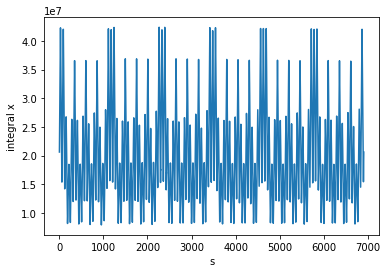

In [36]:
plt.plot(s, dqx)
plt.xlabel('s')
plt.ylabel('integral x')

In [37]:
Ix_trapz_list, Iy_trapz_list = [], []
for i in range(len(dqx_list)):
    Ix_trapz = integrate.trapz(dqx_list[i], s)
    Iy_trapz = integrate.trapz(dqy_list[i], s)
    Ix_trapz_list.append(Ix_trapz)
    Iy_trapz_list.append(Iy_trapz)
    

In [38]:
Dqx = const*np.array(Ix_trapz_list)
Dqy = const*np.array(Iy_trapz_list)

In [39]:
print(Dqx*1e4)
print(Dqy*1e4)

[-3.67807705 -3.20554966 -2.55932334 -2.2688264  -4.86665279 -4.54844992
 -3.32571369 -2.655048  ]
[-5.62423888 -4.11364451 -2.73336057 -2.07332564 -7.40582899 -7.25720853
 -4.15913206 -2.56682384]


In [40]:
# similar vlaues me to integrate quad

In [45]:
print(ey_norm[2], ex_norm[2])

4.95e-06 3.72e-06


In [42]:
Dqy[2]*1e4

-2.733360565407098

In [46]:
print(ey_norm[-1], ex_norm[-1])

5.5e-06 3.3199999999999996e-06


In [47]:
Dqy[-1]*1e4

-2.5668238449922134